#  <center> In Depth Analysis <center>

## Introduction

Importing all the useful libraries

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import os
import sys
import zipfile

from google.colab import files
from google.colab import drive

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import *
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from keras.initializers import HeNormal
from keras.regularizers import l2

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading Speech dataset

**SPEECH**

In [ ]:
speech = '/content/drive/My Drive/Colab Notebooks/Deep Learning/Group project/Ravdess_bis/audio_speech_actors_01-24/'

Creating a dataframe with emotion, path, gender and intensity of each audio file

In [ ]:
ravdess_directory_list = os.listdir(speech)

file_emotion = []
file_path = []
intensity = []
gender = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(speech + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        intensity.append(part[3])
        if int(part[6]) % 2 == 1:
            gender.append('M')
        else:
            gender.append('F')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(speech + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])

gender_df = pd.DataFrame(gender, columns=['Gender'])

intensity_df = pd.DataFrame(intensity, columns=['Intensity'])

Ravdess_df = pd.concat([emotion_df, path_df, gender_df, intensity_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
print(Ravdess_df.Emotions.unique())
Ravdess_df.head()

['sad' 'neutral' 'happy' 'calm' 'angry' 'fear' 'disgust' 'surprise']


,Emotions,Path,Gender,Intensity
0,sad,/content/drive/My Drive/Colab Notebooks/Deep L...,F,01
1,neutral,/content/drive/My Drive/Colab Notebooks/Deep L...,F,01
2,happy,/content/drive/My Drive/Colab Notebooks/Deep L...,F,02
3,happy,/content/drive/My Drive/Colab Notebooks/Deep L...,F,02
4,sad,/content/drive/My Drive/Colab Notebooks/Deep L...,F,01


## Useful things

In [ ]:
sr = 16000

In [ ]:
def mfcc(y, n_mfcc): # generates the MFCC
    return librosa.feature.mfcc(y = y, n_mfcc = n_mfcc, sr = sr)

def noise(data):
    noise_amp = 0.1*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0]) # to be checked
    return data

def pitch_low(data, sr = sr):
    pitch_factor=3
    return librosa.effects.pitch_shift(data, sr = sr, n_steps = pitch_factor)

def pitch_high(data, sr = sr):
    pitch_factor=-3
    return librosa.effects.pitch_shift(data, sr = sr, n_steps = pitch_factor)

def augmenting_data(X, y, techniques):
    # function to augment the dataset using the techniques listed in 'tecnhiques'
    X_out = X
    for technique in techniques:
        function = globals()[technique]
        aug_data = np.apply_along_axis(function, 1, X)
        X_out = np.concatenate((X_out, aug_data))

    y_out = np.tile(y, (len(techniques) + 1, 1))

    return X_out, y_out

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# SPEECH

In [ ]:
df = Ravdess_df

## Shortcut for audio processing

In [ ]:
audio_processed_speech = np.load("/content/drive/My Drive/Colab Notebooks/Deep Learning/Group project/Data/RAVDESS/audio_processed_speech.npy")

## Preparing the data for modelling

In [ ]:
# One hot Encode the labels
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.array(Ravdess_df['Emotions']).reshape(-1,1)).toarray()
sample = range(len(audio_processed_speech))

# Splitting the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test, sample_train_val, sample_test= train_test_split(
    audio_processed_speech, labels, sample, test_size=0.2, random_state=64, shuffle=True)

# Splitting the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=1/8, random_state=64, shuffle=True)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(len(sample_test))

(1008, 36800)
(144, 36800)
(288, 36800)
(1008, 8)
(144, 8)
(288, 8)
288


 We divide the test by gender and intensity

In [ ]:
Ravdess_test = Ravdess_df.iloc[sample_test].reset_index(drop=True)
Ravdess_test_F = Ravdess_test[Ravdess_test.Gender == 'F']
Ravdess_test_M = Ravdess_test[Ravdess_test.Gender == 'M']
Ravdess_test_1 = Ravdess_test[Ravdess_test.Intensity == '01']
Ravdess_test_2 = Ravdess_test[Ravdess_test.Intensity == '02']

The training set gets 3 times bigger adding lowered pitch and highered pitch

In [ ]:
X_train_aug, y_train_aug = augmenting_data(X_train, y_train, ['pitch_high', 'pitch_low']) # to be decided yet

In [ ]:
print(X_train_aug.shape)
print(y_train_aug.shape)

(3024, 36800)
(3024, 8)


Creating the MFCC for all the divided dataset

In [ ]:
n_mfcc = 30

mfcc_train_cnn = np.apply_along_axis(func1d = mfcc, axis = 1, arr = X_train_aug, n_mfcc = n_mfcc)[:,:,:,np.newaxis]

mfcc_val = np.apply_along_axis(func1d = mfcc, axis = 1, arr = X_val, n_mfcc = n_mfcc)[:,:,:,np.newaxis]

mfcc_test = np.apply_along_axis(func1d = mfcc, axis = 1, arr = X_test, n_mfcc = n_mfcc)[:,:,:,np.newaxis]

In [ ]:
print(mfcc_train_cnn.shape)
print(mfcc_val.shape)
print(mfcc_test.shape)
print(y_train_aug.shape)
print(y_val.shape)
print(y_test.shape)

(3024, 30, 72, 1)
(144, 30, 72, 1)
(288, 30, 72, 1)
(3024, 8)
(144, 8)
(288, 8)


## CNN

In [ ]:
input_shape = (mfcc_train_cnn.shape[1:])
inputs = Input(shape=input_shape)

x = Conv2D(64, kernel_size=(5, 5), padding='valid',
           kernel_regularizer=keras.regularizers.L2(0.0001), kernel_initializer=HeNormal())(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, kernel_size=(3, 3), padding='valid', kernel_regularizer=keras.regularizers.L2(0.0001),
           kernel_initializer=HeNormal())(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, kernel_size=(3, 3), padding='valid', kernel_regularizer=keras.regularizers.L2(0.0001),
           kernel_initializer=HeNormal())(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2), name = 'maxpooling_final')(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

x = Dense(128, kernel_regularizer=keras.regularizers.L2(0.0001), kernel_initializer=HeNormal())(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.6)(x)

outputs = Dense(y_train.shape[1], activation='softmax')(x)

cnn_model = keras.Model(inputs=inputs, outputs=outputs)

cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 72, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 68, 64)        1664      
                                                                 
 batch_normalization (Batch  (None, 26, 68, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 26, 68, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 34, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 34, 64)        0     

In [ ]:
optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=10, min_lr=0.0001)

cnn_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
cnn_history = cnn_model.fit(
    x=mfcc_train_cnn,
    y=y_train_aug,
    epochs=200,
    batch_size=32,
    validation_data=(mfcc_val, y_val),
    callbacks=[reduce_lr]
)

Epoch 1/200
95/95 [==============================] - 8s 15ms/step - loss: 2.5580 - accuracy: 0.1987 - val_loss: 3.1798 - val_accuracy: 0.2431 - lr: 0.0010
Epoch 2/200
95/95 [==============================] - 1s 8ms/step - loss: 2.0391 - accuracy: 0.3069 - val_loss: 1.8541 - val_accuracy: 0.3403 - lr: 0.0010
Epoch 3/200
95/95 [==============================] - 1s 8ms/step - loss: 1.8032 - accuracy: 0.3548 - val_loss: 1.5886 - val_accuracy: 0.4236 - lr: 0.0010
Epoch 4/200
95/95 [==============================] - 1s 12ms/step - loss: 1.7313 - accuracy: 0.3803 - val_loss: 1.8188 - val_accuracy: 0.3611 - lr: 0.0010
Epoch 5/200
95/95 [==============================] - 1s 8ms/step - loss: 1.6600 - accuracy: 0.3991 - val_loss: 1.5405 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 6/200
95/95 [==============================] - 1s 8ms/step - loss: 1.5801 - accuracy: 0.4296 - val_loss: 1.7681 - val_accuracy: 0.3819 - lr: 0.0010
Epoch 7/200
95/95 [==============================] - 1s 8ms/step - loss: 1

Plotting neural network performance metrics for train and validation

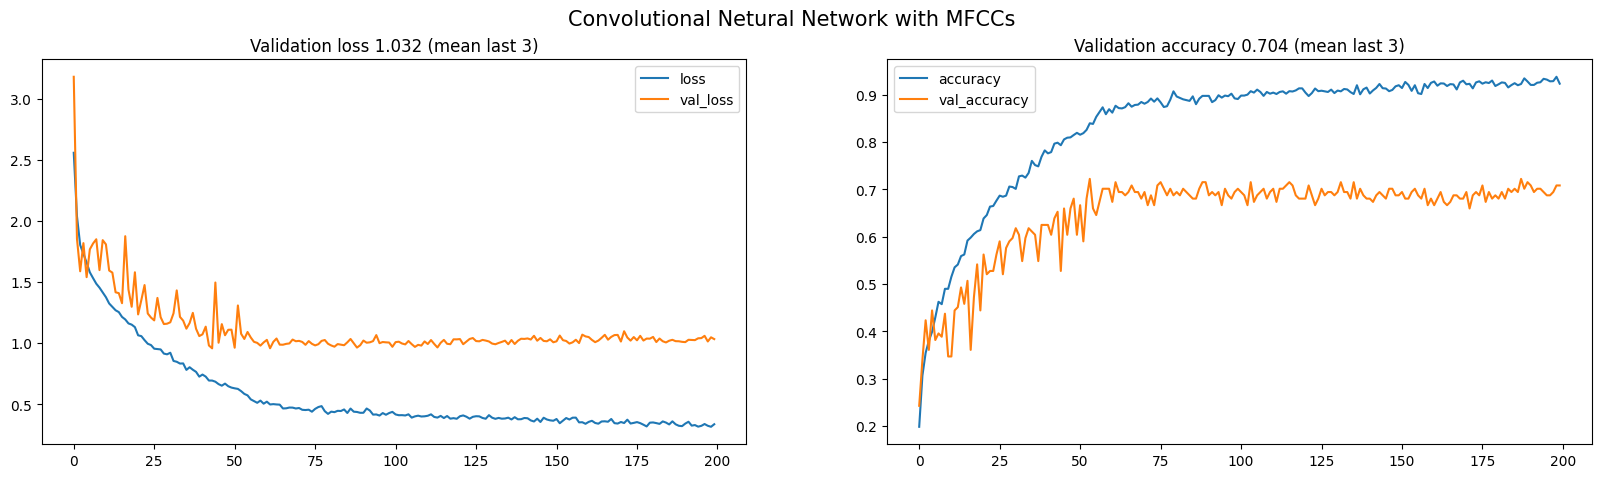

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(cnn_history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(cnn_history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(cnn_history.history["val_accuracy"][-3:])))
plt.show()

In [ ]:
cnn_test_results = pd.DataFrame(columns = ['loss', 'accuracy'], index = ['general', 'female', 'male', 'low intensity', 'high intensity'])

In [ ]:
for i in cnn_test_results.index:
    if i == 'general':
        loss_te, accuracy_te = cnn_model.evaluate(mfcc_test, y_test)
    elif i == 'female':
        loss_te, accuracy_te = cnn_model.evaluate(mfcc_test[list(Ravdess_test_F.index)], y_test[list(Ravdess_test_F.index)])
    elif i == 'male':
        loss_te, accuracy_te = cnn_model.evaluate(mfcc_test[list(Ravdess_test_M.index)], y_test[list(Ravdess_test_M.index)])
    elif i == 'low intensity':
        loss_te, accuracy_te = cnn_model.evaluate(mfcc_test[list(Ravdess_test_1.index)], y_test[list(Ravdess_test_1.index)])
    elif i == 'high intensity':
        loss_te, accuracy_te = cnn_model.evaluate(mfcc_test[list(Ravdess_test_2.index)], y_test[list(Ravdess_test_2.index)])
    cnn_test_results.loc[i] = np.round(loss_te, 2), str(np.round(accuracy_te*100, 2))+'%'

4/4 [==============================] - 0s 72ms/step - loss: 0.7147 - accuracy: 0.8110


Plotting the test results

In [ ]:
cnn_test_results

,loss,accuracy
general,0.79,80.9%
female,0.54,86.11%
male,1.04,75.69%
low intensity,0.85,80.75%
high intensity,0.71,81.1%


In [ ]:
cnn_test_results.to_latex()

'\\begin{tabular}{lll}\n\\toprule\n & loss & accuracy \\\\\n\\midrule\ngeneral & 0.790000 & 80.9% \\\\\nfemale & 0.540000 & 86.11% \\\\\nmale & 1.040000 & 75.69% \\\\\nlow intensity & 0.850000 & 80.75% \\\\\nhigh intensity & 0.710000 & 81.1% \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
cnn_pred_test = cnn_model.predict(mfcc_test)
cnn_y_pred_test = encoder.inverse_transform(cnn_pred_test)

y_test_inv = encoder.inverse_transform(y_test)

9/9 [==============================] - 0s 4ms/step


For the first 10 observation of the test set we see how the model is predicting

In [ ]:
cnn_diff_test = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
cnn_diff_test['Predicted Labels'] = cnn_y_pred_test.flatten()
cnn_diff_test['Actual Labels'] = y_test_inv.flatten()

cnn_diff_test.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,calm,calm
2,sad,sad
3,fear,sad
4,surprise,surprise
5,angry,angry
6,angry,angry
7,angry,disgust
8,angry,angry
9,surprise,surprise


Confusion matrix of the test set

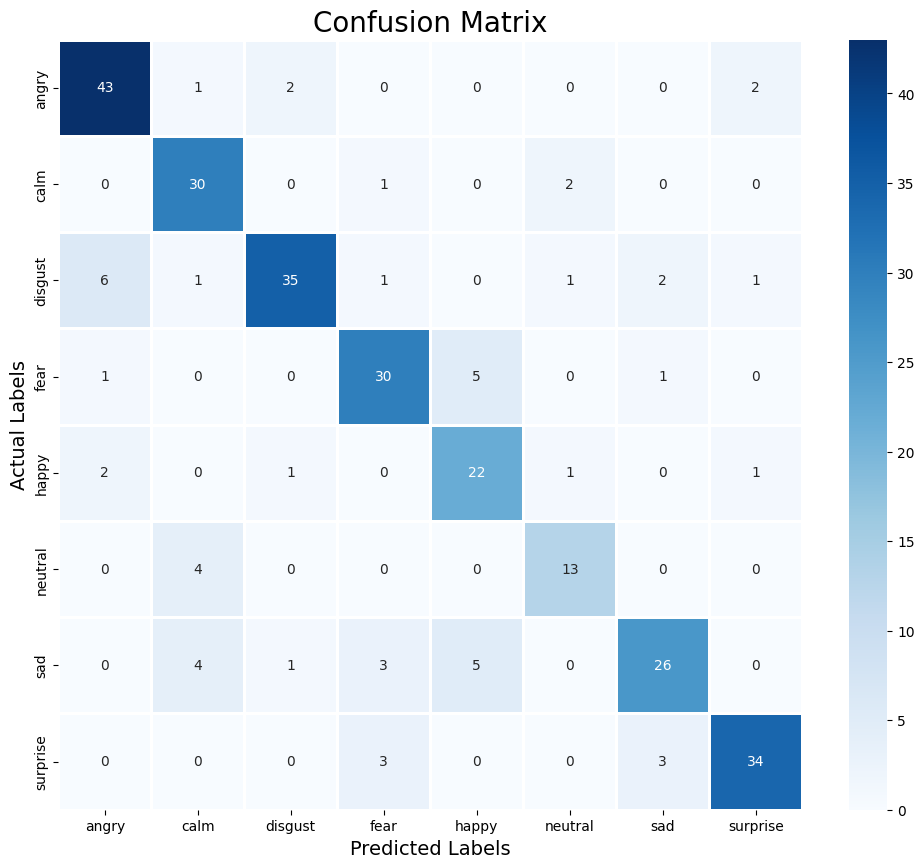

In [ ]:
cm = confusion_matrix(y_test_inv, cnn_y_pred_test)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test_inv, cnn_y_pred_test))

              precision    recall  f1-score   support

       angry       0.83      0.90      0.86        48
        calm       0.75      0.91      0.82        33
     disgust       0.90      0.74      0.81        47
        fear       0.79      0.81      0.80        37
       happy       0.69      0.81      0.75        27
     neutral       0.76      0.76      0.76        17
         sad       0.81      0.67      0.73        39
    surprise       0.89      0.85      0.87        40

    accuracy                           0.81       288
   macro avg       0.80      0.81      0.80       288
weighted avg       0.82      0.81      0.81       288



Interpretation of training

In [ ]:
cnn_pred_train = cnn_model.predict(mfcc_train_cnn)
cnn_y_pred_train = encoder.inverse_transform(cnn_pred_train)

y_train_inv = encoder.inverse_transform(y_train_aug)

95/95 [==============================] - 1s 7ms/step


In [ ]:
cnn_diff_train = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
cnn_diff_train['Predicted Labels'] = cnn_y_pred_train.flatten()
cnn_diff_train['Actual Labels'] = y_train_inv.flatten()

In [ ]:
cnn_diff_train[cnn_diff_train['Predicted Labels'] == 'neutral'].head(10)

,Predicted Labels,Actual Labels
9,neutral,neutral
17,neutral,neutral
24,neutral,neutral
29,neutral,neutral
37,neutral,neutral
51,neutral,neutral
63,neutral,neutral
87,neutral,neutral
121,neutral,neutral
129,neutral,neutral


Looking at gradcams

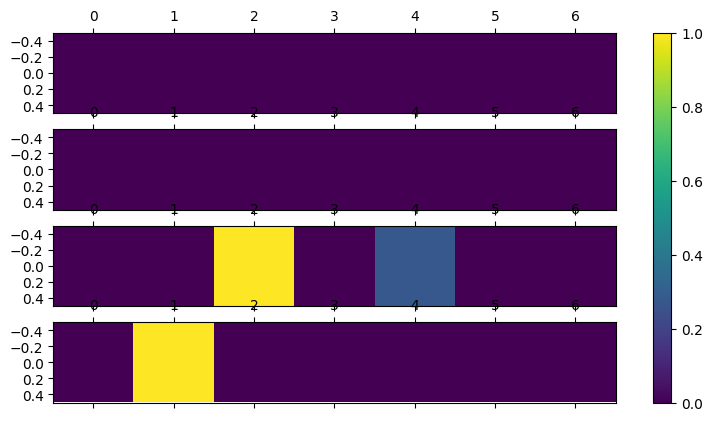

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=plt.figaspect(0.5))
heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[9], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

axs[0].matshow(heatmap)
axs[0].grid(False)

heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[51], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

axs[1].matshow(heatmap)
axs[1].grid(False)

heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[24], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

axs[2].matshow(heatmap)
axs[2].grid(False)

heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[29], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

col = axs[3].matshow(heatmap)
axs[3].grid(False)

fig.colorbar(col, ax=axs.ravel().tolist(), orientation='vertical')
fig.show()

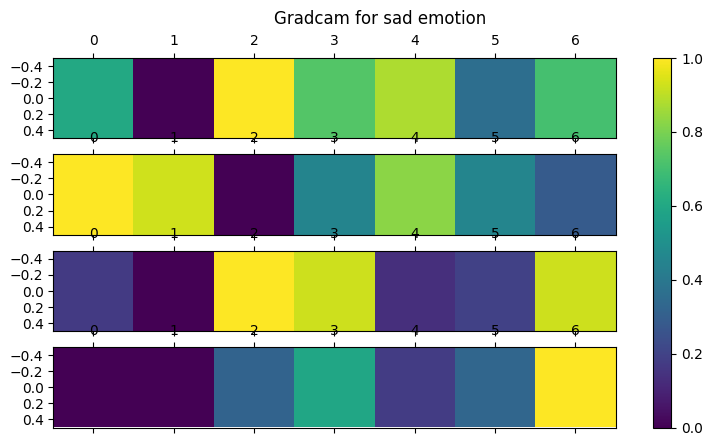

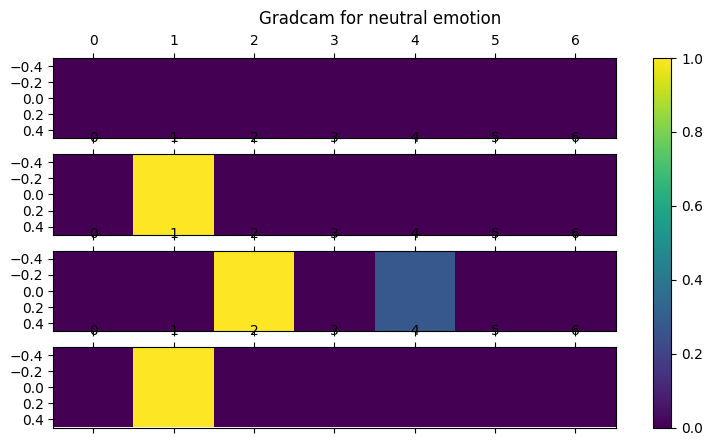

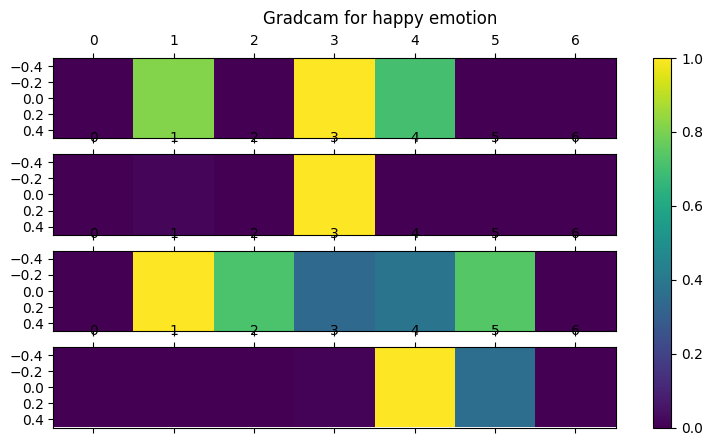

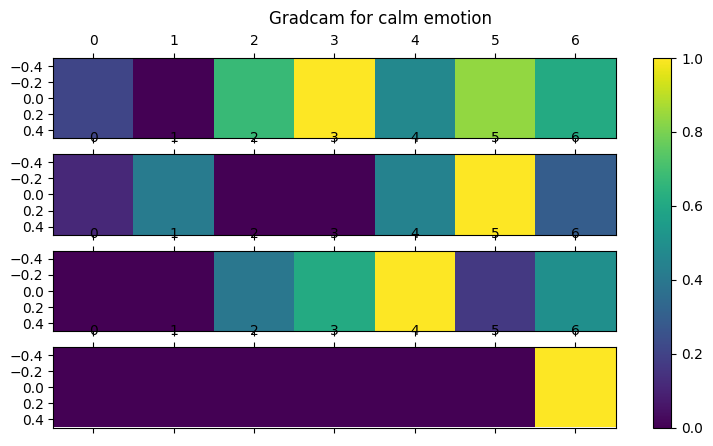

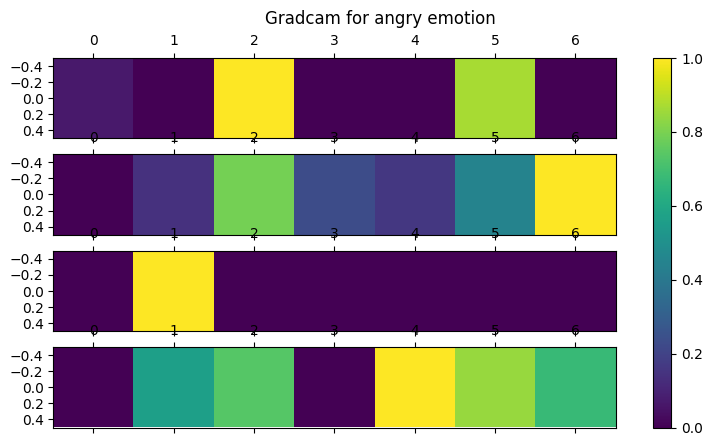

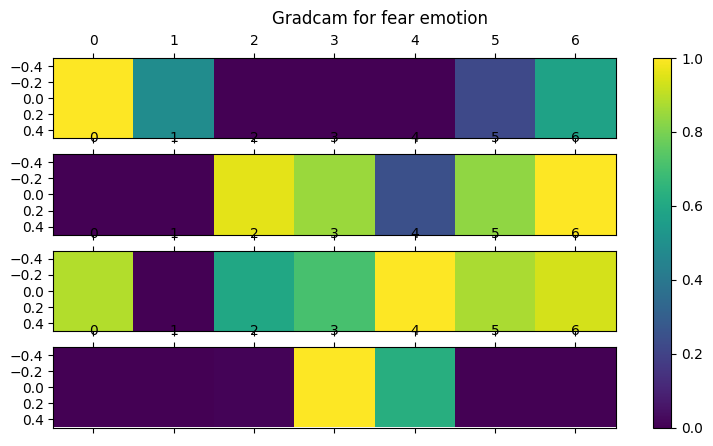

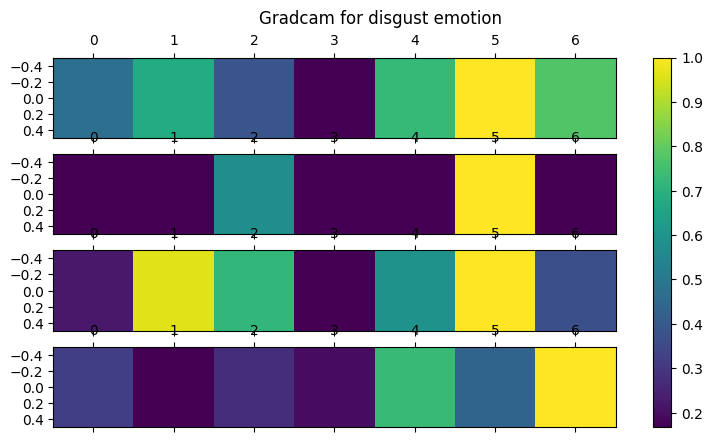

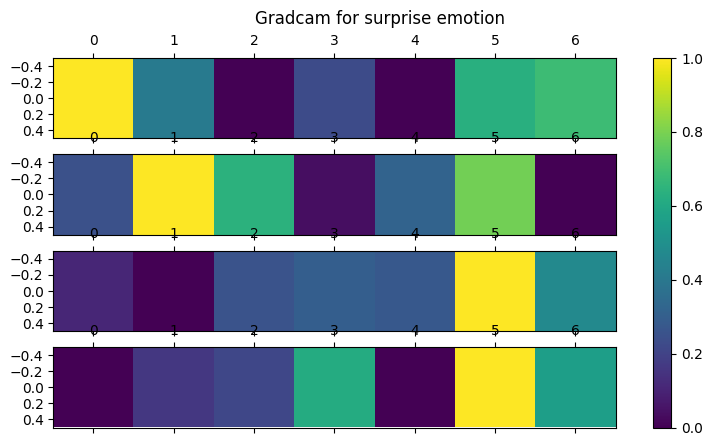

In [ ]:
for emotion in df.Emotions.unique():
    per_emotion = cnn_diff_train[cnn_diff_train['Predicted Labels'] == emotion]
    list_emotion_pos = list(per_emotion.index)
    fig, axs = plt.subplots(4, 1, figsize=plt.figaspect(0.5))
    heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[list_emotion_pos[0]], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

    axs[0].matshow(heatmap)
    axs[0].grid(False)

    heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[list_emotion_pos[1]], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

    axs[1].matshow(heatmap)
    axs[1].grid(False)

    heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[list_emotion_pos[2]], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

    axs[2].matshow(heatmap)
    axs[2].grid(False)

    heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[list_emotion_pos[3]], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

    col = axs[3].matshow(heatmap)
    axs[3].grid(False)

    fig.colorbar(col, ax=axs.ravel().tolist(), orientation='vertical')
    fig.suptitle('Gradcam for '+ emotion + ' emotion')
    fig.show()

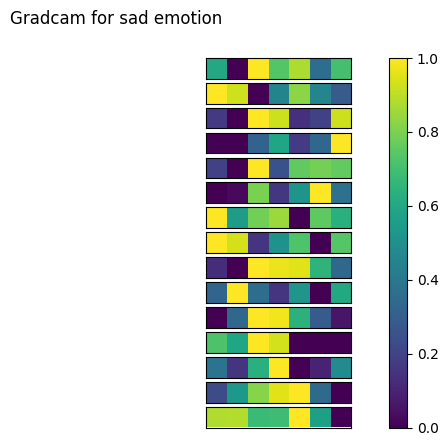

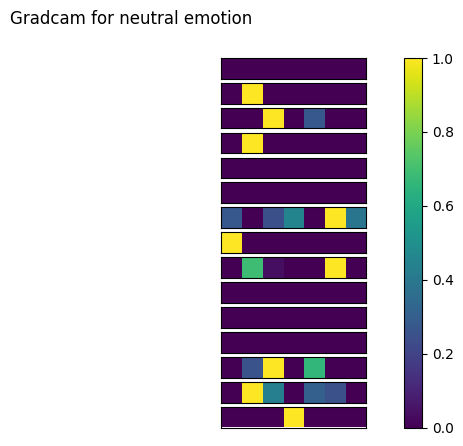

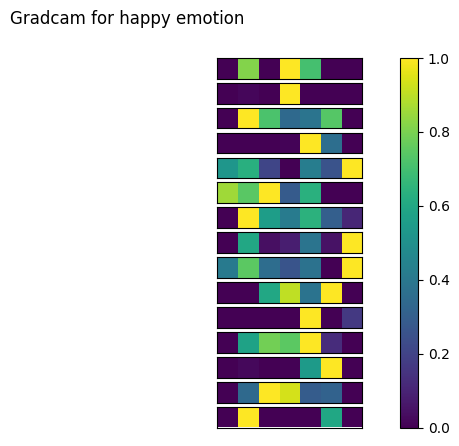

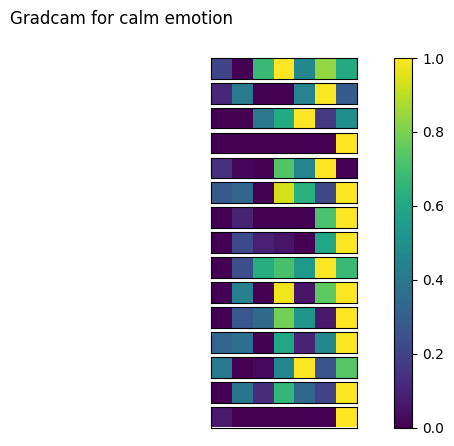

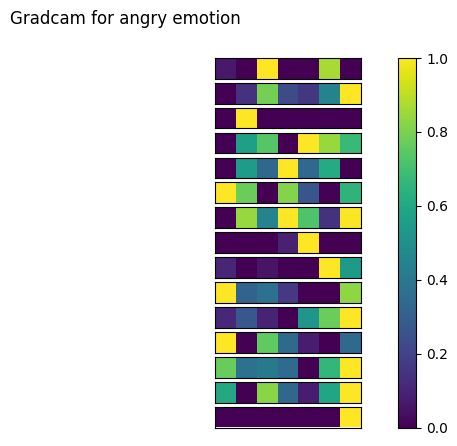

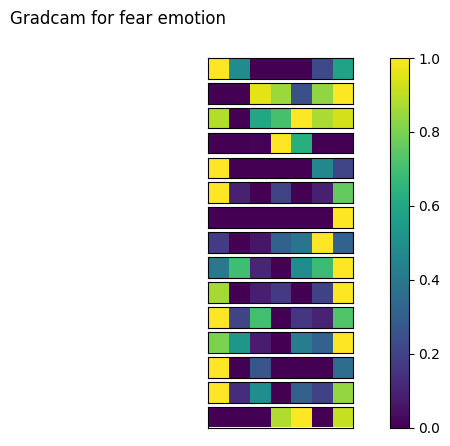

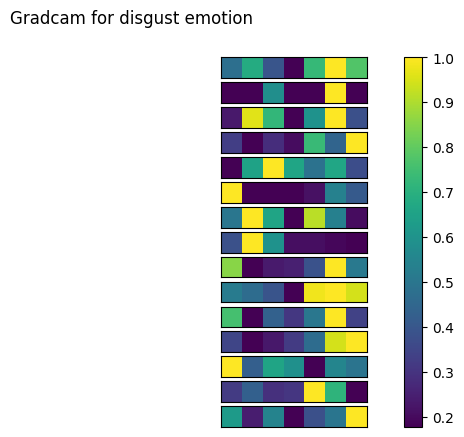

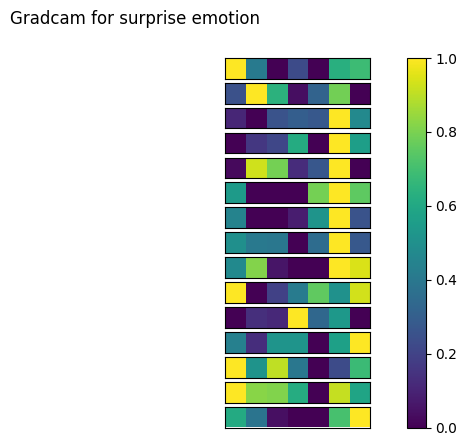

In [ ]:
for emotion in df.Emotions.unique():
    per_emotion = cnn_diff_train[cnn_diff_train['Predicted Labels'] == emotion]
    list_emotion_pos = list(per_emotion.index)
    fig, axs = plt.subplots(15, 1, figsize=plt.figaspect(0.5))
    for i in range(15):
        heatmap = make_gradcam_heatmap(tf.expand_dims(mfcc_train_cnn[list_emotion_pos[i]], axis = 0), cnn_model, 'maxpooling_final').reshape(1,7)

        col = axs[i].matshow(heatmap)
        axs[i].grid(False)
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    fig.colorbar(col, ax=axs.ravel().tolist(), orientation='vertical')
    fig.suptitle('Gradcam for '+ emotion + ' emotion')
    fig.show()

## PCR

Creating the mfcc to fit the parallel structure

In [ ]:
def mfcc(y, n_mfcc):
    return librosa.feature.mfcc(y = y, n_mfcc = n_mfcc).T

In [ ]:
mfcc_train_pcr = np.apply_along_axis(func1d = mfcc, axis = 1, arr = X_train_aug, n_mfcc = n_mfcc)[:,:,:,np.newaxis]
mfcc_val_pcr = np.apply_along_axis(func1d = mfcc, axis = 1, arr = X_val, n_mfcc = n_mfcc)[:,:,:,np.newaxis]
mfcc_test_pcr = np.apply_along_axis(func1d = mfcc, axis = 1, arr = X_test, n_mfcc = n_mfcc)[:,:,:,np.newaxis]

In [ ]:
print(mfcc_train_pcr.shape)
print(mfcc_val_pcr.shape)
print(mfcc_test_pcr.shape)

(3024, 72, 30, 1)
(144, 72, 30, 1)
(288, 72, 30, 1)


In [ ]:
input = Input(shape=mfcc_train_pcr.shape[1:])

cnn = (Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(input)
cnn = (BatchNormalization())(cnn)
cnn = (Activation('elu'))(cnn)
cnn = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))(cnn)
cnn = (Dropout(0.2))(cnn)

## Second LFLB (local feature learning block)
cnn = (Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(cnn)
cnn = (BatchNormalization())(cnn)
cnn = (Activation('elu'))(cnn)
cnn = (MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(cnn)
cnn = (Dropout(0.2))(cnn)

## Second LFLB (local feature learning block)
cnn = (Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(cnn)
cnn = (BatchNormalization())(cnn)
cnn = (Activation('elu'))(cnn)
cnn = (MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(cnn)
cnn = (Dropout(0.2))(cnn)

## Second LFLB (local feature learning block)
cnn = (Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'))(cnn)
cnn = (BatchNormalization())(cnn)
cnn = (Activation('elu'))(cnn)
cnn = (MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))(cnn)
cnn = (Dropout(0.2))(cnn)

## Flat
cnn = (Flatten())(cnn)
cnn = (Dropout(0.2))(cnn)

gru = Reshape((mfcc_train_pcr.shape[1], -1))(input)
gru = (GRU(128, return_sequences=False, kernel_regularizer=l2(0.01), kernel_initializer=HeNormal()))(gru)
gru = Dropout(0.6)(gru)

combined = Concatenate()([cnn, gru])
combined = Dense(128, activation='relu', kernel_regularizer=l2(0.01), kernel_initializer=HeNormal())(combined)
combined = Dropout(0.6)(combined)

output = Dense(y_train.shape[1], activation='softmax')(combined)

parallel_model = keras.Model(inputs=input, outputs=output)

parallel_model.summary()

Model: "model_519"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 72, 30, 1)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 72, 30, 128)          1280      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_16 (Ba  (None, 72, 30, 128)          512       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 72, 30, 128)          0         ['batch_normalization_

In [ ]:
parallel_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
parallel_history = parallel_model.fit(
    x=mfcc_train_pcr,
    y=y_train_aug,
    epochs=200,
    batch_size=32,
    validation_data=(mfcc_val_pcr, y_val),
    callbacks=[reduce_lr]
)

Epoch 1/200
95/95 [==============================] - 5s 30ms/step - loss: 11.9073 - accuracy: 0.1634 - val_loss: 10.4941 - val_accuracy: 0.1597 - lr: 1.0000e-04
Epoch 2/200
95/95 [==============================] - 2s 20ms/step - loss: 10.0200 - accuracy: 0.1987 - val_loss: 9.4968 - val_accuracy: 0.2083 - lr: 1.0000e-04
Epoch 3/200
95/95 [==============================] - 2s 19ms/step - loss: 9.1816 - accuracy: 0.2110 - val_loss: 8.8439 - val_accuracy: 0.1736 - lr: 1.0000e-04
Epoch 4/200
95/95 [==============================] - 2s 18ms/step - loss: 8.5751 - accuracy: 0.2186 - val_loss: 8.3167 - val_accuracy: 0.1458 - lr: 1.0000e-04
Epoch 5/200
95/95 [==============================] - 2s 19ms/step - loss: 8.0885 - accuracy: 0.2123 - val_loss: 7.8624 - val_accuracy: 0.2153 - lr: 1.0000e-04
Epoch 6/200
95/95 [==============================] - 2s 19ms/step - loss: 7.6543 - accuracy: 0.2457 - val_loss: 7.5011 - val_accuracy: 0.2431 - lr: 1.0000e-04
Epoch 7/200
95/95 [========================

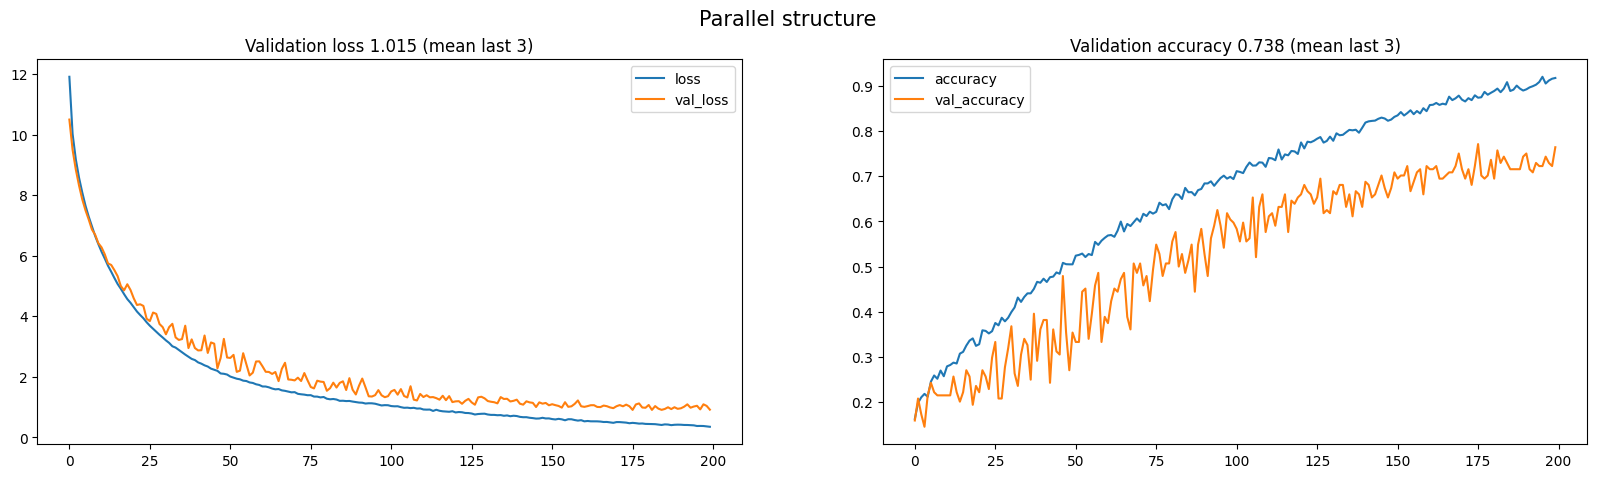

In [ ]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Parallel structure', size=15)
results = pd.DataFrame(parallel_history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(parallel_history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(parallel_history.history["val_accuracy"][-3:])))
plt.show()

In [ ]:
parallel_test_results = pd.DataFrame(columns = ['loss', 'accuracy'], index = ['general', 'female', 'male', 'low intensity', 'high intensity'])

In [ ]:
for i in parallel_test_results.index:
    if i == 'general':
        loss_te, accuracy_te = parallel_model.evaluate(mfcc_test_pcr, y_test)
    elif i == 'female':
        loss_te, accuracy_te = parallel_model.evaluate(mfcc_test_pcr[list(Ravdess_test_F.index)], y_test[list(Ravdess_test_F.index)])
    elif i == 'male':
        loss_te, accuracy_te = parallel_model.evaluate(mfcc_test_pcr[list(Ravdess_test_M.index)], y_test[list(Ravdess_test_M.index)])
    elif i == 'low intensity':
        loss_te, accuracy_te = parallel_model.evaluate(mfcc_test_pcr[list(Ravdess_test_1.index)], y_test[list(Ravdess_test_1.index)])
    elif i == 'high intensity':
        loss_te, accuracy_te = parallel_model.evaluate(mfcc_test_pcr[list(Ravdess_test_2.index)], y_test[list(Ravdess_test_2.index)])
    parallel_test_results.loc[i] = np.round(loss_te, 2), str(np.round(accuracy_te*100, 2))+'%'

4/4 [==============================] - 0s 119ms/step - loss: 0.7251 - accuracy: 0.8031


In [ ]:
parallel_test_results

,loss,accuracy
general,0.84,76.04%
female,0.72,79.86%
male,0.95,72.22%
low intensity,0.93,72.67%
high intensity,0.73,80.31%


In [ ]:
parallel_test_results.to_latex()

'\\begin{tabular}{lll}\n\\toprule\n & loss & accuracy \\\\\n\\midrule\ngeneral & 0.840000 & 76.04% \\\\\nfemale & 0.720000 & 79.86% \\\\\nmale & 0.950000 & 72.22% \\\\\nlow intensity & 0.930000 & 72.67% \\\\\nhigh intensity & 0.730000 & 80.31% \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
# predicting on test data.
par_pred_test = parallel_model.predict(mfcc_test_pcr)
par_y_pred = encoder.inverse_transform(par_pred_test)

9/9 [==============================] - 1s 11ms/step


In [ ]:
par_diff = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
par_diff['Predicted Labels'] = par_y_pred.flatten()
par_diff['Actual Labels'] = y_test_inv.flatten()

par_diff.head(10)

,Predicted Labels,Actual Labels
0,happy,happy
1,calm,calm
2,happy,sad
3,happy,sad
4,surprise,surprise
5,surprise,angry
6,angry,angry
7,disgust,disgust
8,angry,angry
9,surprise,surprise


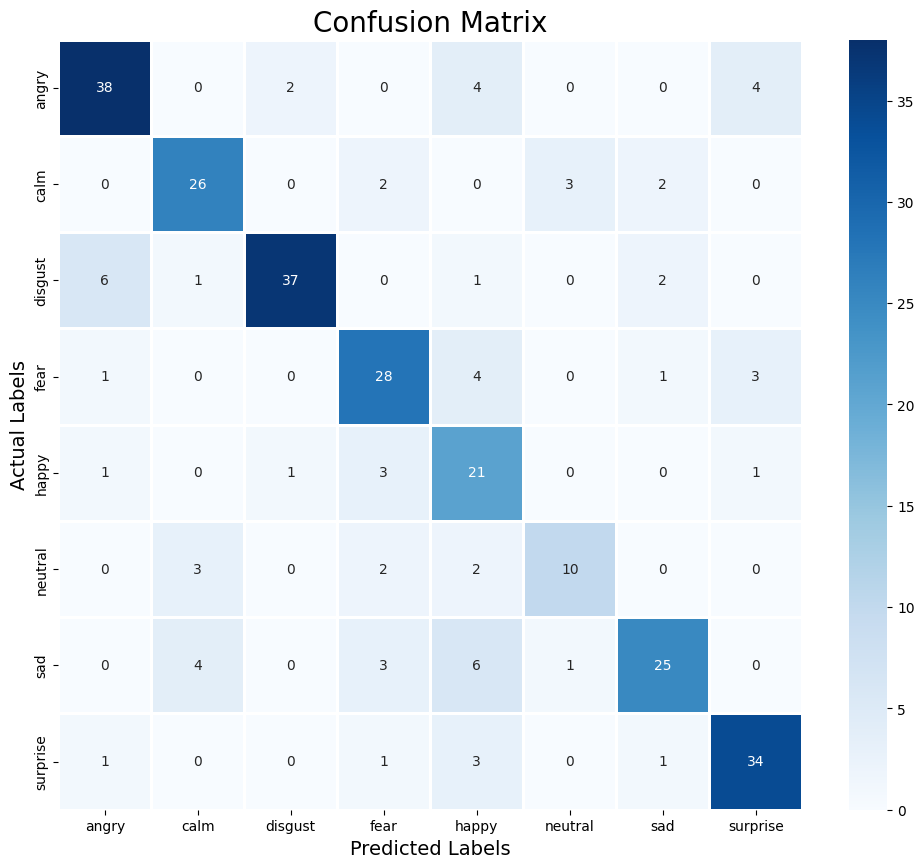

In [ ]:
cm = confusion_matrix(y_test_inv, par_y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test_inv, par_y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.79      0.80        48
        calm       0.76      0.79      0.78        33
     disgust       0.93      0.79      0.85        47
        fear       0.72      0.76      0.74        37
       happy       0.51      0.78      0.62        27
     neutral       0.71      0.59      0.65        17
         sad       0.81      0.64      0.71        39
    surprise       0.81      0.85      0.83        40

    accuracy                           0.76       288
   macro avg       0.76      0.75      0.75       288
weighted avg       0.78      0.76      0.76       288

